Universidad Galileo

Statistical Learning 2

PAPD - Sección V

Sergio José Barrios Martínez

Carnet No. 19012765

# Proyecto Final Curso

## Parte No. 3:
## Sentiment Analysis con Transfer Learning (ELMo Embeddings) y RNN Tipo BiLSTM

Para esta parte del proyecto se trabajará un modelo de Sentiment Analysis sobre un conjunto de reviews de tres sitios de Internet. El dataset puede encontrarse en https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences# e incluye sentencias de opinión de:
- **yelp.com** 
- **imdb.com** 
- **amazon.com**

Con el objetivo de experimentar con el contenido de clase, se utilizará un modelo pre-entrenado para realizar la conversión de palabras a vectores o "embedding" del tipo contextualizado con el modelo **ELMo**. Posteriormente, esta salida se utilizará para entrenar una Red Neuronal Recurrente del tipo **BiLSTM**, con una arquitectura experimental, con el objetivo de obtener un 85% de precisión en la tarea de clasificación de reviews positivos sobre el dataset.

### ELMo (Embeddings from Language Models)
ELMo es un modelo de "embeddings" para conversión contextualizada de palabras a vectores, detallado en el paper **"Deep contextualized word representations"** (https://arxiv.org/pdf/1802.05365.pdf). Utiliza un modelo Bi-Direccional de Lenguaje (biLM) que fue entrenado sobre un corpus de texto bastante extenso. En el presente trabajo se aprovecha este conocimiento aprendido en el modelo de "embedding" para aplicarlo en datos similares (**Transfer Learning**) y alimentar estas representaciones a una **Red Neuronal Recurrente del tipo BiLSTM**, que es el propósito de la parte 3 del proyecto.



In [1]:
import re
import os
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
import keras
from tensorflow.keras.layers import Input, Lambda, Bidirectional, Dense, Dropout 
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

Using TensorFlow backend.


In [2]:
if tf.__version__.startswith("2."):
    import tensorflow.compat.v1 as tf
    tf.compat.v1.disable_eager_execution()
    print("Enabled compatibility to tf1.x")

Enabled compatibility to tf1.x


### Carga de Datasets
El dataset es balanceado, con 500 reviews positivos y 500 reviews negativos para cada sitio, haciendo un total de 3000 reviews a ser clasificados.

In [3]:
yelp = pd.read_csv('.\dataset\yelp_labelled.txt',sep='\t')
yelp

,Review,Sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1
...,...,...
995,I think food should have flavor and texture an...,0
996,Appetite instantly gone.,0
997,Overall I was not impressed and would not go b...,0
998,"The whole experience was underwhelming, and I ...",0


In [4]:
imdb = pd.read_csv('.\dataset\imdb_labelled.txt',sep='\t')
imdb

,Review,Sentiment
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1
...,...,...
995,I just got bored watching Jessice Lange take h...,0
996,"Unfortunately, any virtue in this film's produ...",0
997,"In a word, it is embarrassing.",0
998,Exceptionally bad!,0


In [5]:
amazon = pd.read_csv('.\dataset\Amazon_labelled.txt',sep='\t')
amazon

,Review,Sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1
...,...,...
995,The screen does get smudged easily because it ...,0
996,What a piece of junk.. I lose more calls on th...,0
997,Item Does Not Match Picture.,0
998,The only thing that disappoint me is the infra...,0


### Distribución de Labels (Sentimientos) del Dataset

In [6]:
dataframe = pd.concat([yelp, imdb, amazon])
dataframe['Sentiment'].value_counts()

1    1500
0    1500
Name: Sentiment, dtype: int64

### Normalización de Texto
Aunque no es un requisito, se realiza una normalización básica del texto, con el objetivo de facilitar la tarea de ELMo para hacer el embedding. En este caso, eliminamos espacios, caractéres de nueva linea, retorno y especiales. Finalmente, transformamos el texto a letra minúscula.

In [7]:
def normalizacion(documento):
    documento = documento.strip().replace("\n", " ").replace("\r", " ")
    documento = re.sub(r'[,!@#$%^&*)(|/><";:.?\'\\}{]',"",documento)
    documento = documento.lower()
    return documento

In [8]:
reviews = np.array(dataframe["Review"].apply(normalizacion))
sentiments = np.array(dataframe["Sentiment"])

### Conjuntos de Entrenamiento y Test
Con el objetivo de realizar métricas de evaluación sobre el modelo, se segmenta el conjunto de datos en conjunto de entrenamiento y conjunto de validación (80%-20%)

In [9]:
x_entrenamiento, x_test, y_entrenamiento, y_test= train_test_split(reviews, sentiments, test_size=0.20, random_state=24)

Las etiquetas no necesitan codificación adicional, pues están en formato binario en el dataset original.

In [10]:
y_entrenamiento

array([1, 0, 0, ..., 0, 1, 1], dtype=int64)

### Modelo ELMo con Tensor-hub
Para realizar la carga de los parámetros de ELMo, se utliza TensorFlow Hub

In [11]:
ELMo = "https://tfhub.dev/google/elmo/2"
embed = hub.Module(ELMo,trainable=False)

### Embeddings utilizando ELMo (Transfer Learning)
En esta función se realiza el casteo de los tensores de entrada, ya que el modelo acepta cadenas de caracteres únicamente. 

In [12]:
def ELMoEmbedding(input_text):
    return embed(tf.reshape(tf.cast(input_text, tf.string), [-1]), signature="default", as_dict=True)["elmo"]

### Arquitectura del Modelo
Se especifica la arquitectura del modelo. Esta sección fue sujeta a experimentación, con las siguientes restricciones:
- Utilizar una capa de "embedding" con Transfer Learning del modelo ELMo cargado.
- Alimentar una Red Neuronal Recurrente (en este caso se obtuvieron mejores resultados con un Modelo Bidireccional LSTM)
- Aplicar Técnicas de Regularización (en este caso se experimento con Dropout recurrente y Dropout en Capas Explícitas).
- Función de Costo para Clasificación Binaria (Entropía Cruzada).
- Optimizador (en este caso se cambió el SGD por Adam).
- Métrica de Evaluación: Accuracy

In [13]:
def build_model():
    input_layer = Input(shape=(1,), dtype="string", name="Input_layer")
    embedding_layer = Lambda(ELMoEmbedding, output_shape=(1024, ), name="Elmo_Embedding")(input_layer)
    BiLSTM = Bidirectional(tf.keras.layers.LSTM(10, return_sequences= False, recurrent_dropout=0.2, dropout=0.2), name="BiLSTM")(embedding_layer)
    Dense_layer_1 = Dense(50, activation='relu')(BiLSTM)
    Dropout_layer_1 = Dropout(0.5)(Dense_layer_1)
    output_layer = Dense(1, activation='sigmoid')(Dropout_layer_1)
    model = Model(inputs=[input_layer], outputs=output_layer, name="BiLSTM with ELMo Embeddings")
    model.summary()
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model
elmo_BiDirectional_model = build_model()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "BiLSTM with ELMo Embeddings"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     [(None, 1)]               0         
_________________________________________________________________
Elmo_Embedding (Lambda)      (None, None, 1024)        0         
_________________________________________________________________
BiLSTM (Bidirectional)       (None, 20)                82800     
_________________________________________________________________
dense (Dense)                (None, 50)                1050      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 83,901
Trainable params: 83,901
Non-trainable params: 0
___________________________________

### Grafo
<img src="./imagenes/Grafo.png">

### Hiper-parámetros de Entrenamiento
En esta fase, se experimentó con 5 épocas, con un batch reducido de 32 (aunque hizo un poco más lento el entrenamiento, evitó el colapso de la memoria). Estos hiper-parámetros, en conjunto con el número de capas y parámetros especifican el **string de configuración** que sirvió para guardar la historia de la experimentación utilizando **Keras Callbacks**

In [14]:
parametro_epochs = 5
parametro_batch_size = 32

### Keras Callbacks
Con el propósito de llevar una bitácora de experimentación, se utilizó la función de **Keras Callbacks** específicamente para dos tareas:
- Realizar checkpoints de entrenamiento. En esta fase, con cada epoch se almacena el modelo completo. Esto ayuda a reanudar un entrenamiento en caso de algún fallo o interrupción, desde el último punto de guardado. Esto se guardó en una carpeta llamada **checkpoints** dentro del respositorio
- Bitácora de Resultados y Grafo en TensorBoard. En esta se pueden observar el comportamiento de las métricas de evaluación sobre el set de entrenamiento y el set de pruebas por cada epoch.

In [15]:
logdir = '.\logs\Epochs_'+str(parametro_epochs)+'_BS_'+str(parametro_batch_size)+'_Lyrs_'+str(len(elmo_BiDirectional_model.layers))+'_Params_'+str(elmo_BiDirectional_model.count_params())

if not os.path.exists(logdir):
    os.mkdir(logdir)

callbacks = [

    tf.keras.callbacks.ModelCheckpoint(filepath='./checkpoints/RedNeuronal.Epoch_{epoch:02d}-Val_Loss_{val_loss:.2f}.h5',
                                          save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=False),
    tf.keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=0, profile_batch = 100000000)
]

### Entrenamiento Red Neuronal Recurrente Bi-LSTM con embeddings ELMo
Se realizar el entrenamiento utilizando la función **fit** de Keras. Sobre este conjunto de entrenamiento se indica una nueva segmentación del 20% para el conjunto de pruebas, y se especifican el número de epochs y el tamaño del batch para el Mini-Batch. Así mismo, se envían los *callbacks*.

### Deployment
En este caso se almacenan los parámetros del modelo a disco, como **"model_elmo_weights.h5"**

In [16]:
with tf.Session() as session:
    
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    
    history = elmo_BiDirectional_model.fit(
        x = x_entrenamiento, 
        y = y_entrenamiento, 
        epochs=parametro_epochs, 
        batch_size=parametro_batch_size, 
        validation_split = 0.2,
        callbacks=callbacks
    )
    
    
    elmo_BiDirectional_model.save_weights('./model_elmo_weights.h5')

Train on 1920 samples, validate on 480 samples
Epoch 1/5
1920/1920 [==============================] - 27s 14ms/sample - loss: 0.6314 - accuracy: 0.6510 - val_loss: 0.5061 - val_accuracy: 0.7875
Epoch 2/5
1920/1920 [==============================] - 23s 12ms/sample - loss: 0.4391 - accuracy: 0.8260 - val_loss: 0.3999 - val_accuracy: 0.8313
Epoch 3/5
1920/1920 [==============================] - 28s 14ms/sample - loss: 0.3326 - accuracy: 0.8740 - val_loss: 0.3293 - val_accuracy: 0.8542
Epoch 4/5
1920/1920 [==============================] - 25s 13ms/sample - loss: 0.2809 - accuracy: 0.8922 - val_loss: 0.3667 - val_accuracy: 0.8458
Epoch 5/5
1920/1920 [==============================] - 36s 19ms/sample - loss: 0.2273 - accuracy: 0.9182 - val_loss: 0.3300 - val_accuracy: 0.8667


In [17]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### Historial de Desempeño del Entrenamiento

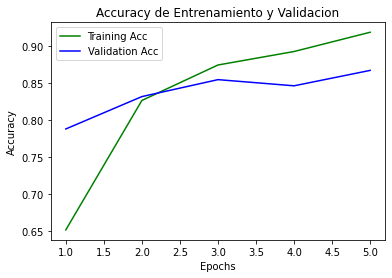

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Accuracy de Entrenamiento y Validacion')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## TensorBoard
### Accuracy en el Set de Entrenamiento

<img src="./imagenes/accuracy_train.png">

### Costo en el Set de Entrenamiento

<img src="./imagenes/loss_train.png">

### Accuracy en el Set de Validación

<img src="./imagenes/accuracy_val.png">

### Predicción sobre Conjunto de Pruebas
Se prueba ahora cargar el modelo después del **deployment** y se realizan predicciones sobre el conjunto de prueba segmentado al inicio con scikit-learn. Debido a la salida probabilística de Sigmoid, se utiliza un umbral estándar de 0.5 para distinguir entre reviews positivos y negativos.

In [19]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    elmo_BiDirectional_model.load_weights('./model_elmo_weights.h5')  
    y_predicts = elmo_BiDirectional_model.predict(x_test, batch_size=32)

In [20]:
umbral = 0.5
y_predicts[y_predicts>=umbral]=1
y_predicts[y_predicts<umbral]=0

### Métricas de Evaluación
Se implementa con sklearn:
- Matriz de Confusión
- Reporte de Métricas

In [21]:
from sklearn import metrics
matriz_confusion = metrics.confusion_matrix(y_test, y_predicts)

reporte = metrics.classification_report(y_test, y_predicts)

In [22]:
print(matriz_confusion)

[[258  44]
 [ 35 263]]


In [23]:
print(reporte)

              precision    recall  f1-score   support

           0       0.88      0.85      0.87       302
           1       0.86      0.88      0.87       298

    accuracy                           0.87       600
   macro avg       0.87      0.87      0.87       600
weighted avg       0.87      0.87      0.87       600



Se muestra con este resultado que el accuracy logrado sobre el set de pruebas es de **87%**.